In [8]:
START_TOKEN = '<SOS>'.lower()
END_TOKEN = '<EOS>'.lower()

DATA_PATH = 'data/poetry.txt'

CUTOFF = 0.8
EPOCHES = 2000
NUM_LAYERS = 1
BATCH_SIZE = 128
LATENT_DIM = 25
EMBEDDING_DIM = 50
LEARNING_RATE = 0.01

In [21]:
import os
import torch
from tqdm import tqdm
from torchsummary import summary
import torchnlp.encoders.text as text_encoder
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [10]:
def load_data():
    input_lines = []
    target_lines = []
    for line in open(DATA_PATH):
        line = line.strip()
        
        input_line = '{} {}'.format(START_TOKEN, line)
        target_line = '{} {}'.format(line, END_TOKEN)
        
        input_lines.append(input_line)
        target_lines.append(target_line)
        
    return input_lines, target_lines

In [11]:
def tokenize_line(line, encoder):
    return encoder.encode(line)

def tokenize_lines(lines, encoder):
    return [tokenize_line(line, encoder) for line in lines]

def extract_max_length(all_seq_lengths):
    return torch.max(all_seq_lengths).item()
    
def padding_line(tokens, MAX_LENGTH):
    return text_encoder.pad_tensor(
                                tokens, 
                                length = MAX_LENGTH
                                )

def padding_lines(all_tokens):
    return text_encoder.stack_and_pad_tensors(
                                            all_tokens
                                            )

def process_line(line, encoder, MAX_LENGTH):
    tokens = tokenize_line(line, encoder)
    padded = padding_line(tokens, MAX_LENGTH)
    return padded

def process_lines(lines, encoder):
    all_tokens = tokenize_lines(lines, encoder)
    all_padded = padding_lines(all_tokens)
    return all_padded

In [12]:
'''
*** Make target Sequence OneHot ***

    The Reason is that Sparse Categorical Cross Entropy won't work when Target is a Sequence.
'''

def make_one_hot_target_sequences(MAX_LENGTH, vocabulary, target_sequences):
    onehot_target_sequences = torch.empty(
                                    len(target_sequences),
                                    MAX_LENGTH,
                                    len(vocabulary),
                                    dtype=torch.float32
                                        )
    
    for idx, target_sequence in enumerate(target_sequences):
        onehot_target_sequence = torch.nn.functional.one_hot(
                                                    target_sequence, 
                                                    num_classes = len(vocabulary)
                                                    )
        onehot_target_sequences[idx, :, :] = onehot_target_sequence
        
    return onehot_target_sequences

In [13]:
def process_data():
    input_lines, target_lines = load_data()
    all_lines = input_lines + target_lines
    encoder = text_encoder.StaticTokenizerEncoder(
                                                all_lines, 
                                                tokenize = lambda s: s.split()
                                                )

    input_sequences, input_seq_lengths = process_lines(input_lines, encoder)
    target_sequences, target_seq_lengths = process_lines(target_lines, encoder)
    all_sequences, all_seq_lengths = process_lines(all_lines, encoder)

    MAX_LENGTH = extract_max_length(all_seq_lengths)
    vocabulary = encoder.vocab
    
    assert START_TOKEN in vocabulary, 'START_TOKEN NOT FOUND' 
    assert END_TOKEN in vocabulary, 'END_TOKEN NOT FOUND' 
    
    target_sequences = make_one_hot_target_sequences(
                                                    MAX_LENGTH,
                                                    vocabulary, 
                                                    target_sequences
                                                    )
    
    return input_sequences, input_seq_lengths, target_sequences, target_seq_lengths, encoder, MAX_LENGTH

In [14]:
class LanguageGenerator(torch.nn.Module):
    def __init__(
                self,
                VOCAB_SIZE,
                DEVICE
                ):
        super(LanguageGenerator,self).__init__()
        
        self.embedding_layer = torch.nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.lstm_layer = torch.nn.LSTM(
                                    input_size=EMBEDDING_DIM, 
                                    hidden_size=LATENT_DIM,
                                    num_layers=NUM_LAYERS, 
                                    batch_first=True
                                    ) 

        self.linear_layer = torch.nn.Linear(LATENT_DIM, VOCAB_SIZE)
        
        
        self.DEVICE = DEVICE
        self.VOCAB_SIZE = VOCAB_SIZE

    def forward(self, x, memory_init):
        x = x.long()
        
        x = self.embedding_layer(x)
        x, _ = self.lstm_layer(x, memory_init) 
        
        '''
        
        output shape : (CHUNK_SIZE, MAX_LENGTH, LATENT_DIM)
             --> Always return_sequences = True
        
        '''
        x = self.linear_layer(x)
        return x

In [16]:
class LanguageModelingPyTorch(object):
    def __init__(self):
        input_sequences, input_seq_lengths, target_sequences, target_seq_lengths, encoder, MAX_LENGTH = process_data()
        
        dataset = TensorDataset(
                        input_sequences, 
                        target_sequences
                                )
        
        train_data, valid_data = torch.utils.data.random_split(dataset, 
                                                              [int(len(input_sequences) * CUTOFF), len(input_sequences) - int(len(input_sequences) * CUTOFF)])
        
        train_loader = DataLoader(
                            train_data, 
                            shuffle=False, 
                            drop_last=True,
                            batch_size=BATCH_SIZE
                                )
    
        valid_loader = DataLoader(
                            valid_data, 
                            shuffle=False, 
                            drop_last=True,
                            batch_size=BATCH_SIZE
                                )
        
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.VOCAB_SIZE = len(encoder.vocab)
        self.DEVICE = torch.device('cpu' if not torch.cuda.is_available() else 'cuda:0') 
        
        h_init = torch.zeros(
                        NUM_LAYERS, 
                        BATCH_SIZE, 
                        LATENT_DIM
                        ).to(self.DEVICE) # Teacher Forcing Stratergy
        
        c_init = torch.zeros(
                        NUM_LAYERS, 
                        BATCH_SIZE, 
                        LATENT_DIM
                        ).to(self.DEVICE) # Teacher Forcing Stratergy
        

        h_init_eval = torch.zeros(
                        NUM_LAYERS, 
                        1, 
                        LATENT_DIM
                        ).to(self.DEVICE) # Predict for Individual Word
        
        c_init_eval = torch.zeros(
                        NUM_LAYERS, 
                        1, 
                        LATENT_DIM
                        ).to(self.DEVICE) # Predict for Individual Word
        
        self.memory_init = (h_init, c_init)
        self.memory_init_eval = (h_init_eval, c_init_eval)
            
    def language_generator(self):        
        model = LanguageGenerator(
                                self.VOCAB_SIZE, 
                                self.DEVICE
                                    )
        
        self.model = model.to(self.DEVICE)
        
        self.optimizer = torch.optim.Adam(
                                    self.model.parameters(),
                                    lr = LEARNING_RATE
                                        )
        self.criterion = torch.nn.CrossEntropyLoss()
        
    def train_epoch(self):
          
        train_loss_epoch = 0
        valid_loss_epoch = 0
        self.model.train()
        
        for Xbatch, Ybatch in self.train_loader:
            self.optimizer.zero_grad()
            
            Xbatch = Xbatch.to(self.DEVICE)
            Ybatch = Ybatch.to(self.DEVICE)
        
            CHUNK_SIZE = Xbatch.shape[0]
            
            Pbatch = self.model(Xbatch, self.memory_init).to(self.DEVICE)

            train_loss = self.criterion(Pbatch, Ybatch)
            train_loss.backward()
            self.optimizer.step()
            
            train_loss_epoch += train_loss.item()
            
        train_loss_epoch = train_loss_epoch / len(self.train_loader)
        
        self.model.eval()
        
        for Xbatch, Ybatch in self.valid_loader:

            Xbatch = Xbatch.to(self.DEVICE)
            Ybatch = Ybatch.to(self.DEVICE)
        
            CHUNK_SIZE = Xbatch.shape[0]
            
            Pbatch = self.model(Xbatch,self.memory_init).to(self.DEVICE)

            valid_loss = self.criterion(Pbatch, Ybatch)
            
            valid_loss_epoch += valid_loss.item()
            
        valid_loss_epoch = valid_loss_epoch / len(self.train_loader)
        
        return train_loss_epoch, valid_loss_epoch
            
    def train_loop(self):
        train_loss, valid_loss = [], []
        for epoch in range(EPOCHES):
            train_loss_epoch, valid_loss_epoch = self.train_epoch()
            
            train_loss.append(train_loss_epoch)
            valid_loss.append(valid_loss_epoch)
            
            if (epoch + 1) % 100 == 0:
                print('EPOCH : {}, TRAIN LOSS : {}, VALID LOSS : {}'.format(epoch+1, train_loss_epoch, valid_loss_epoch))
        
        self.train_loss = train_loss
        self.valid_loss = valid_loss
        
    def plot_cross_entropy(self):
        plt.plot(self.train_loss, label='loss')
        plt.plot(self.valid_loss, label='val_loss')
        plt.legend()
        plt.show()
        
    def train(self):
        self.language_generator()
        self.train_loop()
        self.plot_cross_entropy()

EPOCH : 100, TRAIN LOSS : 0.0022117209284462864, VALID LOSS : 0.0016156330497728454
EPOCH : 200, TRAIN LOSS : 0.0021997447410184476, VALID LOSS : 0.0017275071392456691
EPOCH : 300, TRAIN LOSS : 0.002197232045647171, VALID LOSS : 0.0017997092670864528
EPOCH : 400, TRAIN LOSS : 0.0021958982235648567, VALID LOSS : 0.0018522832542657852
EPOCH : 500, TRAIN LOSS : 0.0021955354346169364, VALID LOSS : 0.001896600652900007
EPOCH : 600, TRAIN LOSS : 0.0021954725056679714, VALID LOSS : 0.0019894404750731257
EPOCH : 700, TRAIN LOSS : 0.002194951598842939, VALID LOSS : 0.0020342471284998786
EPOCH : 800, TRAIN LOSS : 0.0021948395943683055, VALID LOSS : 0.0020619306920303237
EPOCH : 900, TRAIN LOSS : 0.0022179053889380563, VALID LOSS : 0.0020912867039442062
EPOCH : 1000, TRAIN LOSS : 0.002195059231275486, VALID LOSS : 0.0021128770377900866
EPOCH : 1100, TRAIN LOSS : 0.002194773884386652, VALID LOSS : 0.002153797075152397
EPOCH : 1200, TRAIN LOSS : 0.002194714137456483, VALID LOSS : 0.0021808570664789

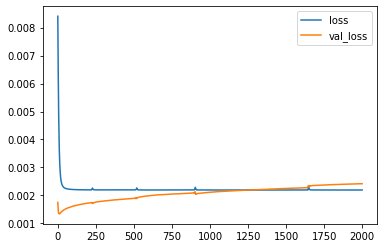

In [17]:
LMP = LanguageModelingPyTorch()
LMP.train()

In [24]:
summary(LMP.model, (12, 1)) 

TypeError: forward() missing 1 required positional argument: 'memory_init'

In [25]:
LMP.model

LanguageGenerator(
  (embedding_layer): Embedding(3291, 50)
  (lstm_layer): LSTM(50, 25, batch_first=True)
  (linear_layer): Linear(in_features=25, out_features=3291, bias=True)
)

In [19]:
for Xbatch, Ybatch in LMP.train_loader:
    Xbatch = Xbatch.to('cuda:0')
    Ybatch = Ybatch.to('cuda:0')

    Pbatch = LMP.model(Xbatch, LMP.memory_init).to('cuda:0')
    print(Pbatch.shape)
    break

torch.Size([128, 12, 3291])


In [24]:
class LanguageGeneratorInference(torch.nn.Module):
    def __init__(
                self,
                VOCAB_SIZE,
                DEVICE,
                model
                ):
        super(LanguageGeneratorInference,self).__init__()
        
        self.embedding_layer = torch.nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.lstm_layer = torch.nn.LSTM(
                                    input_size=EMBEDDING_DIM, 
                                    hidden_size=LATENT_DIM,
                                    num_layers=NUM_LAYERS, 
                                    batch_first=True
                                    ) 

        self.linear_layer = torch.nn.Linear(LATENT_DIM, VOCAB_SIZE)
        
        
        self.DEVICE = DEVICE
        self.VOCAB_SIZE = VOCAB_SIZE

    def forward(self, x, memory_init):
        x = x.long()
        
        x = self.embedding_layer(x)
        x, _ = self.lstm_layer(x, memory_init) 
        
        '''
        
        output shape : (CHUNK_SIZE, MAX_LENGTH, LATENT_DIM)
             --> Always return_sequences = True
        
        '''
        x = self.linear_layer(x)
        return x
    
for layer in LMP.model.modules():
    print(layer)

LanguageGenerator(
  (embedding_layer): Embedding(3291, 50)
  (lstm_layer): LSTM(50, 25, batch_first=True)
  (linear_layer): Linear(in_features=25, out_features=3291, bias=True)
)
Embedding(3291, 50)
LSTM(50, 25, batch_first=True)
Linear(in_features=25, out_features=3291, bias=True)
